# Waring: If there is a tensor uninitialized, it means out of memory rather than the code is wrong.

Import Packages

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import glob # help read files
import seaborn as sns
from keras.utils import np_utils
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.models import Sequential
import tensorflow.compat.v1 as tf
from tensorflow.keras.applications import DenseNet121

Read Image Information

#### Read Train data set

In [2]:
dataset = {"image_path":[],"img_status":[],"where":[]}
path = "D://DeskTop/ML/Project/real_and_fake/training/"
for where in os.listdir(path):
    for status in os.listdir(path+where):
        for image in glob.glob(path+where+"/"+status):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append(where)
dataset = pd.DataFrame(dataset)
print(dataset.shape)
dataset.head()

(4000, 3)


,image_path,img_status,where
0,D://DeskTop/ML/Project/real_and_fake/training/...,001DDU0NI4.jpg,fake
1,D://DeskTop/ML/Project/real_and_fake/training/...,00AUP94LQS.jpg,fake
2,D://DeskTop/ML/Project/real_and_fake/training/...,00B4R41FLE.jpg,fake
3,D://DeskTop/ML/Project/real_and_fake/training/...,00C64W8TYZ.jpg,fake
4,D://DeskTop/ML/Project/real_and_fake/training/...,00CB415UQ7.jpg,fake


#### Read Test data set

In [3]:
dataset1 = {"image_path":[],"img_status":[],"where":[]}
path1 = "D://DeskTop/ML/Project/real_and_fake/test/"
for where in os.listdir(path1):
    for status in os.listdir(path1+where):
        for image in glob.glob(path1+where+"/"+status):
            dataset1["image_path"].append(image)
            dataset1["img_status"].append(status)
            dataset1["where"].append(where)
dataset1 = pd.DataFrame(dataset1)
print(dataset1.shape)
dataset1.head()

(2041, 3)


,image_path,img_status,where
0,D://DeskTop/ML/Project/real_and_fake/test/fake...,easy_100_1111.jpg,fake
1,D://DeskTop/ML/Project/real_and_fake/test/fake...,easy_101_0010.jpg,fake
2,D://DeskTop/ML/Project/real_and_fake/test/fake...,easy_102_0101.jpg,fake
3,D://DeskTop/ML/Project/real_and_fake/test/fake...,easy_103_1111.jpg,fake
4,D://DeskTop/ML/Project/real_and_fake/test/fake...,easy_104_1000.jpg,fake


Define the images label

In [4]:
dataset['Label'] = 0
dataset['Label'][dataset["where"] == "fake"] = 1
dataset['Label'][dataset["where"] == "real"] = 0

C:\Users\ASUS\AppData\Local\Temp/ipykernel_40672/78679185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Label'][dataset["where"] == "fake"] = 1
C:\Users\ASUS\AppData\Local\Temp/ipykernel_40672/78679185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Label'][dataset["where"] == "real"] = 0


In [5]:
dataset1['Label'] = 0
dataset1['Label'][dataset1["where"] == "fake"] = 1
dataset1['Label'][dataset1["where"] == "real"] = 0

C:\Users\ASUS\AppData\Local\Temp/ipykernel_40672/1273387632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1['Label'][dataset1["where"] == "fake"] = 1
C:\Users\ASUS\AppData\Local\Temp/ipykernel_40672/1273387632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1['Label'][dataset1["where"] == "real"] = 0


In [6]:
cv2.imread(dataset['image_path'][0]).shape # check image's shape

(256, 256, 3)

In [7]:
fake = (dataset[dataset["where"] == "fake"])
real = (dataset[dataset["where"] == "real"])

Real: 2000,
Fake: 2000



E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


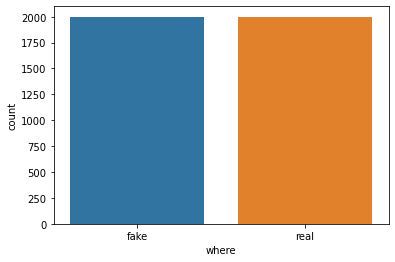

In [8]:
print(f"Real: {len(real)},\nFake: {len(fake)}\n")
sns.countplot(dataset["where"])
plt.show()

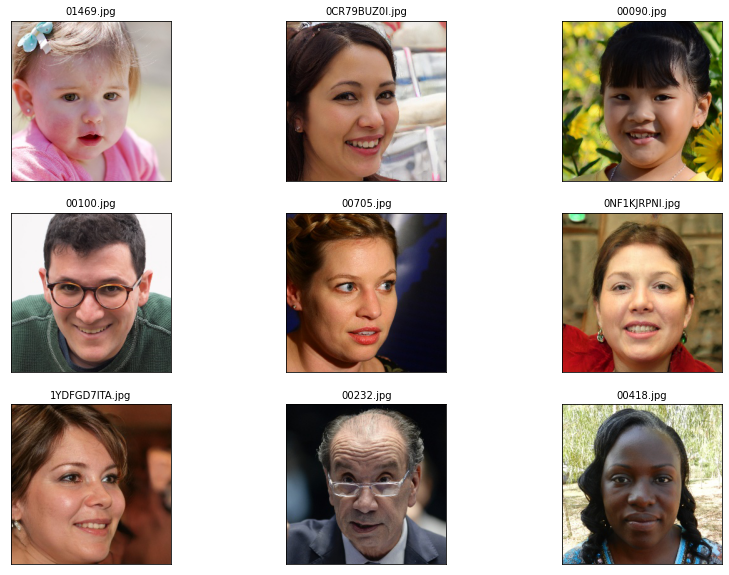

In [9]:
plt.figure(figsize = (14,10))
for i in range(9):
    random = np.random.randint(1,len(dataset))
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random, "img_status"], size = 10) 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

Split the data set randomly

In [10]:
np.random.seed(0)
random_index = np.random.choice(a=len(dataset), size=int(np.ceil(len(dataset)*0.8)), replace=False)
train_index = random_index
test_index = np.array(list(set(np.array(range(len(dataset))))-set(random_index)))
train = dataset.loc[train_index,:]
test = dataset.loc[test_index,:]

Set the initial value for training

In [11]:
# you decide those parameters below
batch_size = 10
num_classes = 2
epochs =  80
# input image dimensions
img_rows, img_cols = 256,256

Image preprocessing
1. Resize
2. Normalization

In [12]:
x= []
for i in range(dataset1.shape[0]):
    img = cv2.imread(dataset1['image_path'].iloc[i])
    img = cv2.resize(img,(224,224))
    x.append(img)
    

In [13]:
x = np.array(x)
x = x.astype('float32')
x /= 255

In [14]:
x_train = []
x_test = []
for i in range(train.shape[0]):
    img = cv2.imread(train['image_path'].iloc[i])
    img = cv2.resize(img,(224,224))
    x_train.append(img)
    
for i in range(test.shape[0]):
    img = cv2.imread(test['image_path'].iloc[i])
    img = cv2.resize(img,(224,224))
    x_test.append(img)

In [15]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [16]:
# y_train = np_utils.to_categorical(train['Label'],2)
# y_test = np_utils.to_categorical(test['Label'],2)
y_train = train['Label'].values
y_test = test['Label'].values

In [17]:
y = dataset1['Label'].values

In [18]:
input_shape = x_train.shape[1:]

In [19]:
input_shape

(224, 224, 3)

Building Model

In [20]:
model = Sequential()
model.call = tf.function(model.call)

model.add(Conv2D(8,kernel_size=(3,3),activation='relu',padding="same",input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding="same"))

model.add(Conv2D(8,kernel_size=(5,5),activation='relu',padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding="same"))

model.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding="same"))

model.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4,4),padding="same"))

model.add(Flatten())

model.add(Dropout(0.5))
model.add(Dense(16))

model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))


In [21]:
model.compile(loss='mean_squared_error',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 8)       1608      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 8)      32        
 hNormalization)                                                 
                                                        

Model Training

In [22]:
history = model.fit(x = x_train, y = y_train,
                   batch_size = 10,
                   epochs = 80,
                   verbose = 1,
                   validation_data = (x_test, y_test))

Epoch 1/80
320/320 [==============================] - 8s 14ms/step - loss: 0.2873 - accuracy: 0.5362 - val_loss: 0.2449 - val_accuracy: 0.5575
Epoch 2/80
320/320 [==============================] - 3s 10ms/step - loss: 0.2527 - accuracy: 0.5788 - val_loss: 0.2322 - val_accuracy: 0.6100
Epoch 3/80
320/320 [==============================] - 3s 10ms/step - loss: 0.2398 - accuracy: 0.5962 - val_loss: 0.2255 - val_accuracy: 0.6438
Epoch 4/80
320/320 [==============================] - 3s 10ms/step - loss: 0.2379 - accuracy: 0.6062 - val_loss: 0.2303 - val_accuracy: 0.6087
Epoch 5/80
320/320 [==============================] - 3s 10ms/step - loss: 0.2280 - accuracy: 0.6212 - val_loss: 0.2156 - val_accuracy: 0.6550
Epoch 6/80
320/320 [==============================] - 3s 10ms/step - loss: 0.2218 - accuracy: 0.6391 - val_loss: 0.2171 - val_accuracy: 0.6463
Epoch 7/80
320/320 [==============================] - 3s 10ms/step - loss: 0.2113 - accuracy: 0.6681 - val_loss: 0.2077 - val_accuracy: 0.6650

In [23]:
# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)

(3200, 224, 224, 3)
(3200,)
(800, 224, 224, 3)
(800,)


Check Accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

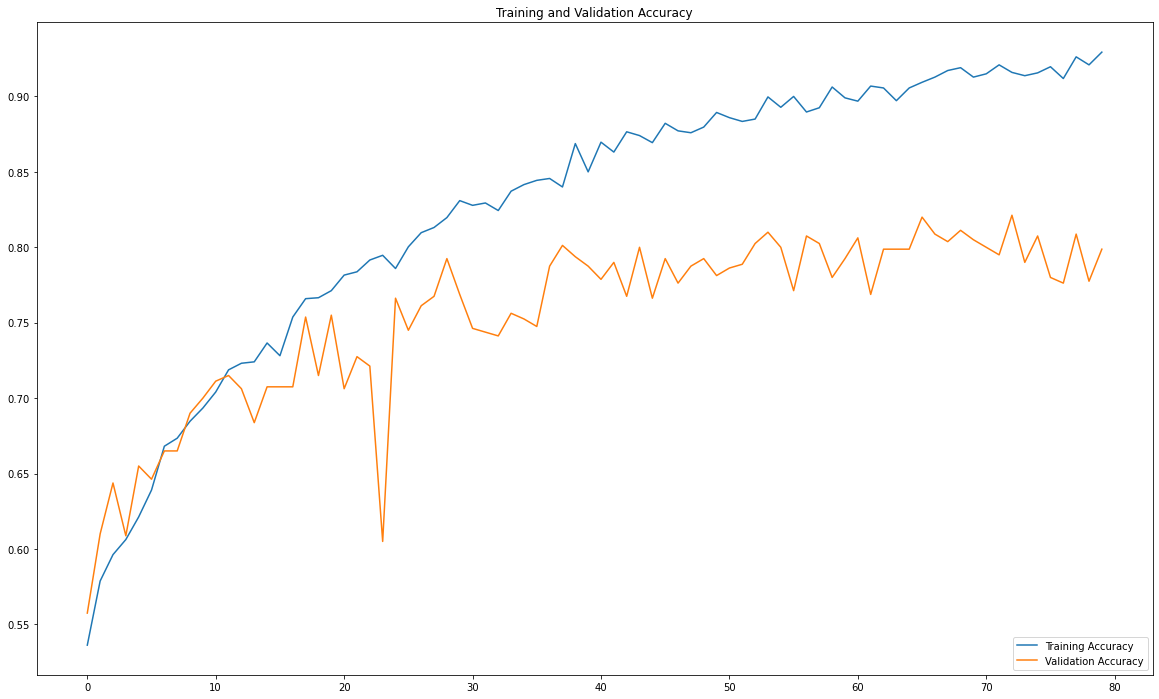

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(80)
plt.figure(figsize=(20, 12))

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Check Loss

<Figure size 1440x864 with 0 Axes>

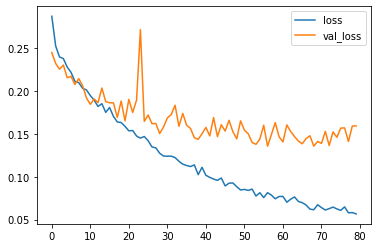

In [25]:

losses = pd.DataFrame(model.history.history)
plt.figure(figsize=(20,12))
losses[['loss','val_loss']].plot()
plt.show()

## Evaluate

For test set

In [26]:
y_pred = (model.predict(x_test)).reshape(x_test.shape[0])
y_pred[y_pred>0.5] = 1 
y_pred[y_pred<0.5] = 0

In [27]:
df1 = pd.DataFrame(y_test,columns=['y_test'])
df2 = pd.DataFrame(y_pred,columns=['y_pred'])

In [28]:
k = pd.merge(df1,df2,how="outer",left_index=True,right_index=True)
k

In [29]:
TP = len(k[(y_test==1) & (y_pred==1)])
FP = len(k[(y_test==0) & (y_pred==1)])
FN = len(k[(y_test==1) & (y_pred==0)])
TN = len(k[(y_test==0) & (y_pred==0)])
print(TP,FP,FN,TN)

In [30]:
Acc = (TP+TN)/(TP+FP+FN+TN)
Pre = (TP)/(TP+FP)
Rec = (TP)/(TP+FN)
F_1 = (2*Pre*Rec)/(Pre+Rec)
print(Acc,Pre,Rec,F_1)

For train set

In [31]:
y_pred = (model.predict(x_train)).reshape(x_train.shape[0])
y_pred[y_pred>0.5] = 1 
y_pred[y_pred<0.5] = 0

In [32]:
df1 = pd.DataFrame(y_train,columns=['y_train'])
df2 = pd.DataFrame(y_pred,columns=['y_pred'])

In [33]:
k = pd.merge(df1,df2,how="outer",left_index=True,right_index=True)
k

In [34]:
TP = len(k[(y_train==1) & (y_pred==1)])
FP = len(k[(y_train==0) & (y_pred==1)])
FN = len(k[(y_train==1) & (y_pred==0)])
TN = len(k[(y_train==0) & (y_pred==0)])
print(TP,FP,FN,TN)

In [35]:
Acc = (TP+TN)/(TP+FP+FN+TN)
Pre = (TP)/(TP+FP)
Rec = (TP)/(TP+FN)
F_1 = (2*Pre*Rec)/(Pre+Rec)
print(Acc,Pre,Rec,F_1)

For predict set

In [36]:
y_pred = (model.predict(x)).reshape(x.shape[0])
y_pred[y_pred>0.5] = 1 
y_pred[y_pred<0.5] = 0

In [37]:
df1 = pd.DataFrame(y,columns=['y'])
df2 = pd.DataFrame(y_pred,columns=['y_pred'])

In [38]:
k = pd.merge(df1,df2,how="outer",left_index=True,right_index=True)
k

,y,y_pred
0,1,0.0
1,1,0.0
2,1,0.0
3,1,0.0
4,1,0.0
...,...,...
2036,0,1.0
2037,0,0.0
2038,0,0.0
2039,0,0.0


In [39]:
TP = len(k[(y==1) & (y_pred==1)])
FP = len(k[(y==0) & (y_pred==1)])
FN = len(k[(y==1) & (y_pred==0)])
TN = len(k[(y==0) & (y_pred==0)])
print(TP,FP,FN,TN)

30 44 930 1037


In [40]:
Acc = (TP+TN)/(TP+FP+FN+TN)
Pre = (TP)/(TP+FP)
Rec = (TP)/(TP+FN)
F_1 = (2*Pre*Rec)/(Pre+Rec)
print(Acc,Pre,Rec,F_1)

0.5227829495345419 0.40540540540540543 0.03125 0.058027079303675046
